In [25]:
# Import necessary libraries
import numpy as np
import tensorflow as tf

In [26]:
import numpy as np 

In [27]:
import os   
import numpy as np
from PIL import Image
import json

In [28]:
data_dir = "Extracted"
image_ext = ".jpg"
json_ext = ".json"

In [29]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [30]:
files = os.listdir(data_dir)

In [31]:
X = []
y = []

for file in files:
    if file.endswith(image_ext):
        filename = file.split(".")[0].split("Image")[1]
        # print(filename)
        image = Image.open(os.path.join(data_dir, file))
        image = image.resize((224, 224))
        image = np.array(image)
        image = image.reshape(224, 224, 3)
        image = image / 255.0

        json_file = os.path.join(data_dir, "Data" + filename + json_ext)
        with open(json_file) as f:
            data = json.load(f)
            try:
                labels = data["MaterialsAndParts"]["1"]["MaterialType_ClassNames"]
            except:
                labels = []
        
        y.append(labels)
        X.append(image)

X = np.array(X)
y = np.array(y)


/var/folders/bh/8d89rfhj5ms3twx_n5_ln2jc0000gn/T/ipykernel_17382/1374342670.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [32]:
import numpy as np
print(np.unique(y))
len(np.unique(y))

[list([]) list(['Filled']) list(['Foam']) list(['Foam', 'Filled'])
 list(['Foam', 'Solid', 'Filled'])
 list(['Foam', 'Solid', 'Granular', 'Powder', 'Filled'])
 list(['Foam', 'Solid', 'Powder'])
 list(['Foam', 'Solid', 'Powder', 'Filled']) list(['Liquid'])
 list(['Liquid', 'Filled']) list(['Liquid', 'Filled', 'Solid'])
 list(['Liquid', 'Foam', 'Filled'])
 list(['Liquid', 'Foam', 'Gel', 'Solid', 'Filled'])
 list(['Liquid', 'Foam', 'Solid', 'Filled'])
 list(['Liquid', 'Foam', 'Solid', 'Granular', 'Filled'])
 list(['Liquid', 'Foam', 'Solid', 'Powder', 'Filled'])
 list(['Liquid', 'Foam', 'Vapor']) list(['Liquid', 'Gel', 'Filled'])
 list(['Liquid', 'Gel', 'Solid'])
 list(['Liquid', 'Gel', 'Solid', 'Filled'])
 list(['Liquid', 'Gel', 'Solid', 'SolidLargChunk', 'Filled'])
 list(['Liquid', 'Granular', 'Filled']) list(['Liquid', 'Solid'])
 list(['Liquid', 'Solid', 'Filled'])
 list(['Liquid', 'Solid', 'Granular', 'Filled'])
 list(['Liquid', 'Solid', 'Other Material', 'Filled'])
 list(['Liquid', 'S

62

In [33]:
np.save("X.npy", X)
np.save("y.npy", y)

In [65]:
X = np.load("X.npy", allow_pickle=True)
y = np.load("y.npy", allow_pickle=True)

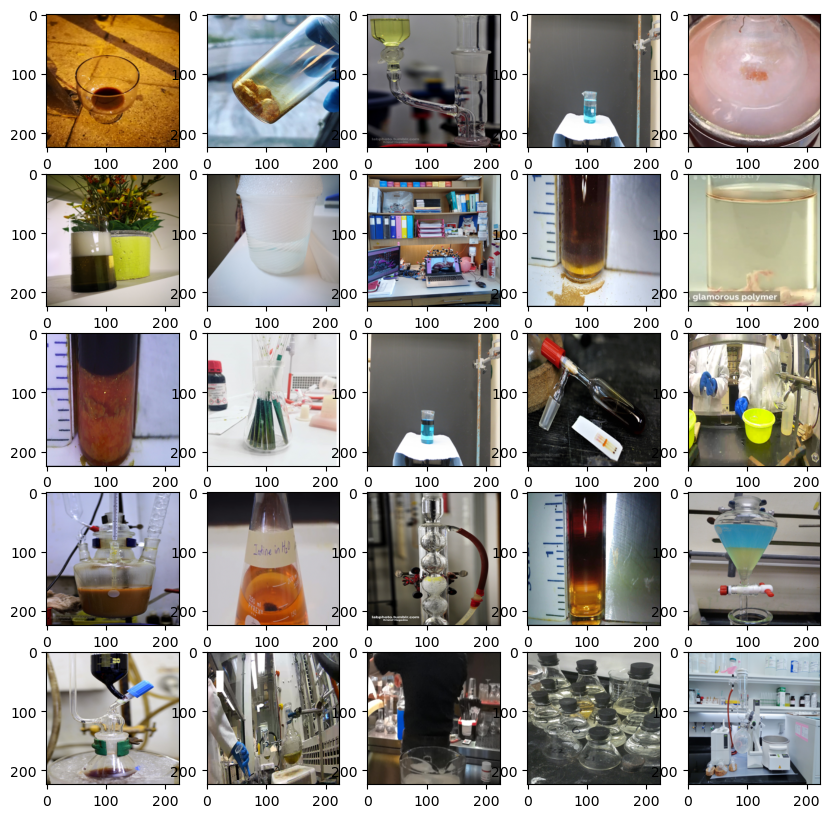

In [44]:
import matplotlib.pyplot as plt

def display_image(image):
    plt.imshow(image)
    # plt.show()

# display_image(X[0])

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    display_image(X[i])

In [66]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
print(mlb.classes_)

for i, label in enumerate(labels):
    print(f"{label}: {y[i]}")

['Filled' 'Foam' 'Gel' 'Granular' 'Liquid' 'Other Material' 'Powder'
 'Solid' 'SolidLargChunk' 'Suspension' 'Vapor']
Liquid: [1 0 0 0 1 0 0 0 0 0 0]
Suspension: [1 0 0 0 0 0 0 1 0 0 0]
Filled: [1 0 0 0 1 0 0 0 0 0 0]


In [46]:
X.shape, y.shape

((6381, 224, 224, 3), (6381, 11))

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [48]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from keras.callbacks import ModelCheckpoint

# convert X and y to tensors
y = tf.convert_to_tensor(y, dtype=tf.float32)
X = tf.convert_to_tensor(X)

split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg'))


for layer in my_new_model.layers:
    layer.trainable = False

x = my_new_model.output
x = Flatten()(x)
x = Dense(11, activation='softmax')(x)


my_new_model = Model(inputs=my_new_model.input, outputs=x)


my_new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False,
    verbose=1)



history = my_new_model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/5
160/160 [==============================] - ETA: 0s - loss: 4.8129 - accuracy: 0.9465
Epoch 1: val_accuracy improved from -inf to 0.96006, saving model to best_model.h5
160/160 [==============================] - 592s 4s/step - loss: 4.8129 - accuracy: 0.9465 - val_loss: 5.1184 - val_accuracy: 0.9601
Epoch 2/5
160/160 [==============================] - ETA: 0s - loss: 5.9959 - accuracy: 0.9579
Epoch 2: val_accuracy did not improve from 0.96006
160/160 [==============================] - 643s 4s/step - loss: 5.9959 - accuracy: 0.9579 - val_loss: 6.1573 - val_accuracy: 0.9601
Epoch 3/5
160/160 [==============================] - ETA: 0s - loss: 7.1031 - accuracy: 0.9579
Epoch 3: val_accuracy did not improve from 0.96006
160/160 [==============================] - 580s 4s/step - loss: 7.1031 - accuracy: 0.9579 - val_loss: 7.1653 - val_accuracy: 0.9601
Epoch 4/5
160/160 [==============================] - ETA: 0s - loss: 8.2757 - accuracy: 0.9579
Epoch 4: val_accuracy did not improve f

In [ ]:
tf.keras.Model.save(my_new_model, "my_new_model.h5")

In [56]:
model = tf.keras.models.load_model("best_model.h5")
tf.saved_model.save(model, "my_model")


INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets


In [49]:
my_new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50_input (InputLayer)  [(None, None, None, 3)]  0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 11)                22539     
                                                                 
Total params: 23,610,251
Trainable params: 22,539
Non-trainable params: 23,587,712
_________________________________________________________________


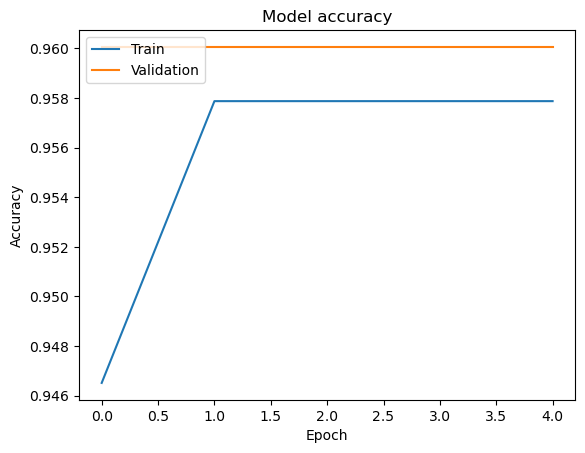

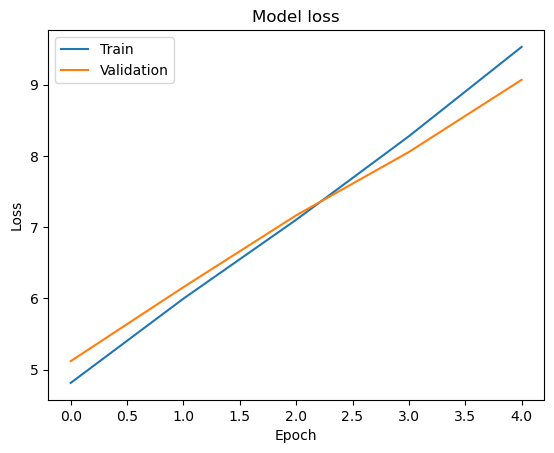

In [50]:
# Plot the training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

4/4 [==============================] - 8s 1s/step


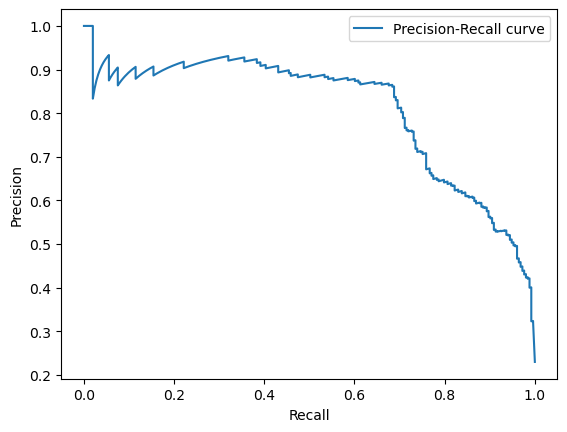

In [51]:
from sklearn.metrics import precision_recall_curve

X = X[:1000]
y = y[:1000]
y_pred = my_new_model.predict(X)
y_true = y.numpy()

precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()


In [61]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [64]:
first_X = X[1].numpy()
pred = my_new_model.predict(first_X.reshape(1, 224, 224, 3))
pred = (pred > 0.5).astype(int)
pred

1/1 [==============================] - 0s 257ms/step


array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Confusion matrix for class Filled


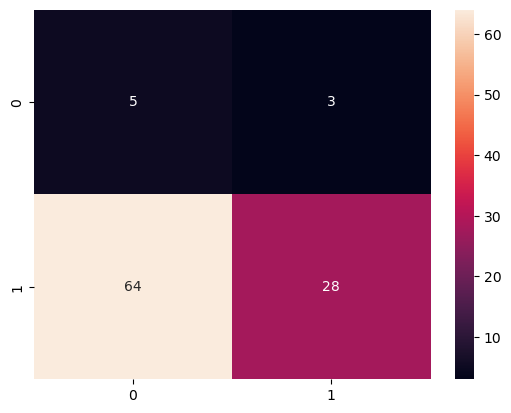

Confusion matrix for class Foam


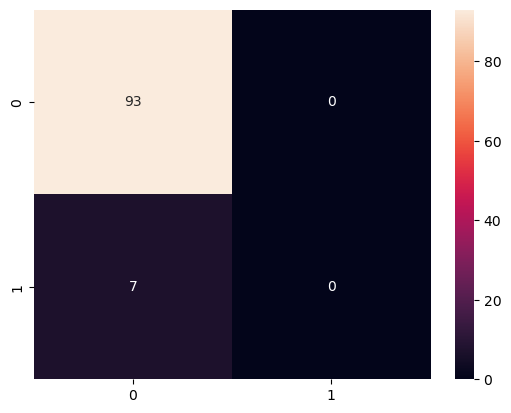

Confusion matrix for class Gel


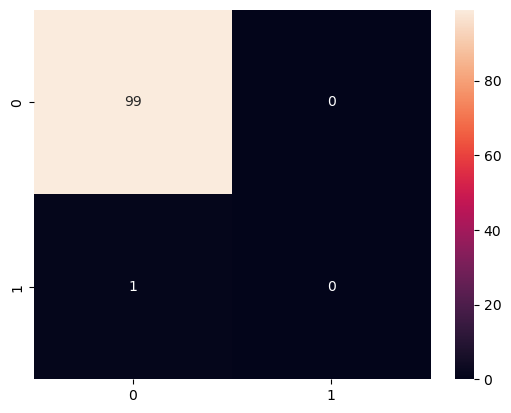

Confusion matrix for class Granular


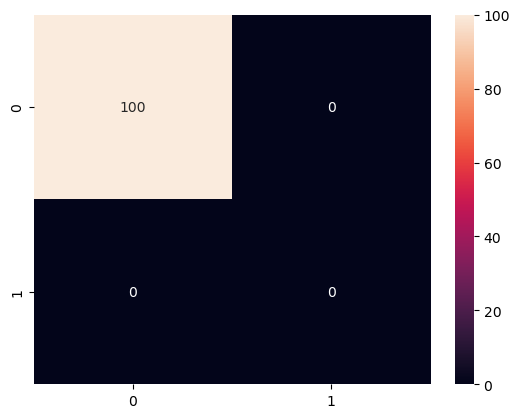

Confusion matrix for class Liquid


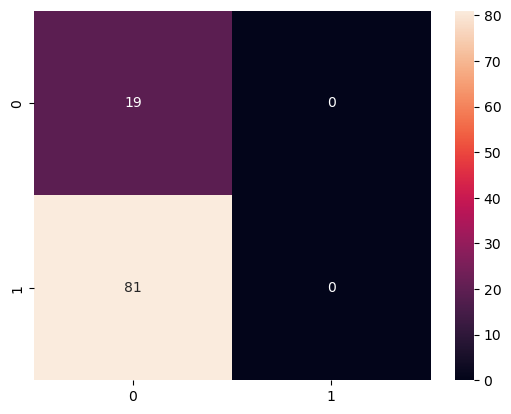

Confusion matrix for class Other Material


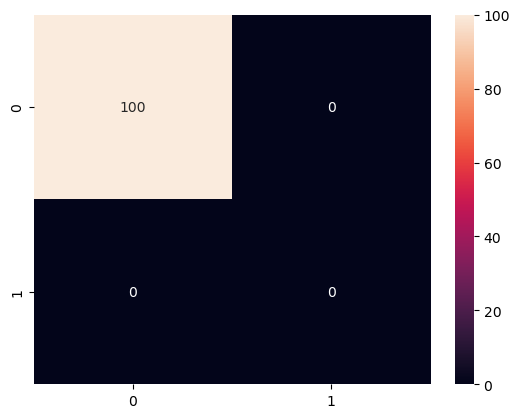

Confusion matrix for class Powder


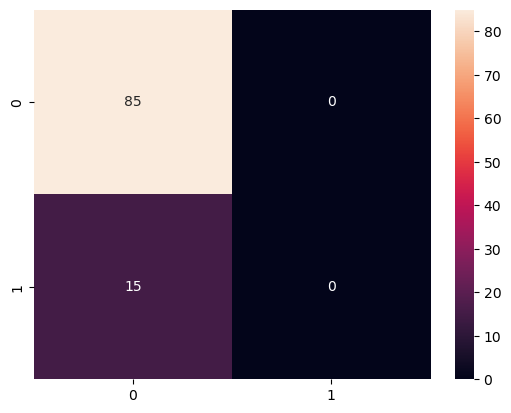

Confusion matrix for class Solid


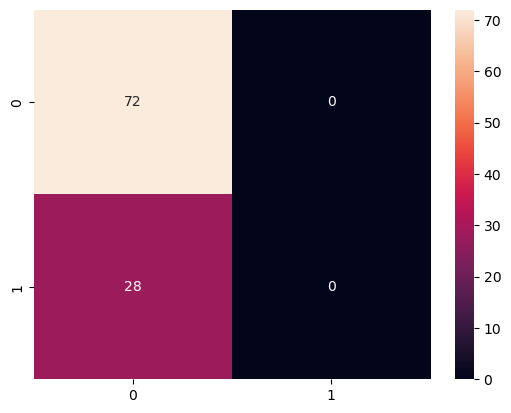

Confusion matrix for class SolidLargChunk


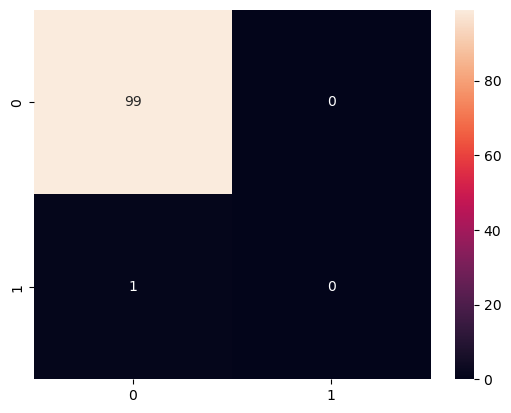

Confusion matrix for class Suspension


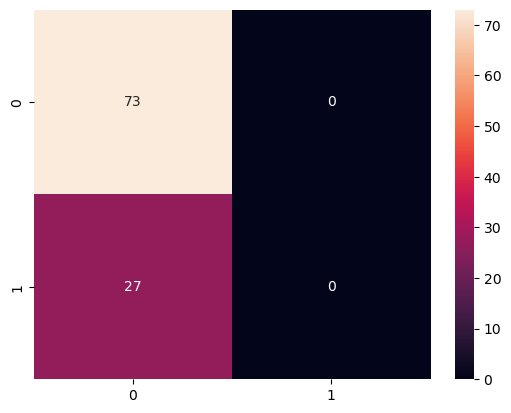

Confusion matrix for class Vapor


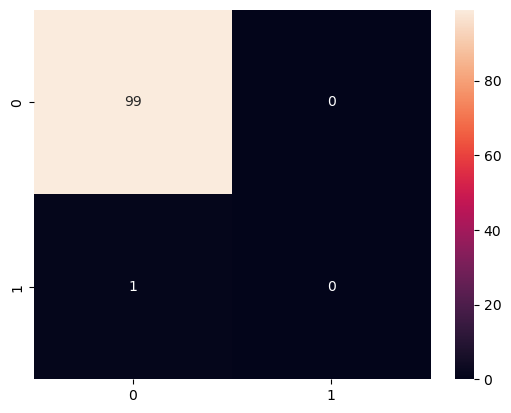

In [52]:
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
# y_pred = my_new_model.predict(X)
# y_true = y

# Convert probabilities to binary predictions
y_pred = (y_pred > 0.5).astype(int)

# Compute the multilabel confusion matrix
cm = multilabel_confusion_matrix(y_true, y_pred)

# Plot the confusion matrix for each class
for i in range(len(mlb.classes_)):
    print(f"Confusion matrix for class {mlb.classes_[i]}")
    sns.heatmap(cm[i], annot=True, fmt="d")
    plt.show()


In [54]:
TP = tf.math.count_nonzero(y_pred * y_true)
TN = tf.math.count_nonzero((y_pred - 1) * (y_true - 1))
FP = tf.math.count_nonzero(y_pred * (y_true - 1))
FN = tf.math.count_nonzero((y_pred - 1) * y_true)

precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
precision.numpy(), recall.numpy(), f1.numpy()

(0.9032258064516129, 0.11067193675889328, 0.1971830985915493)